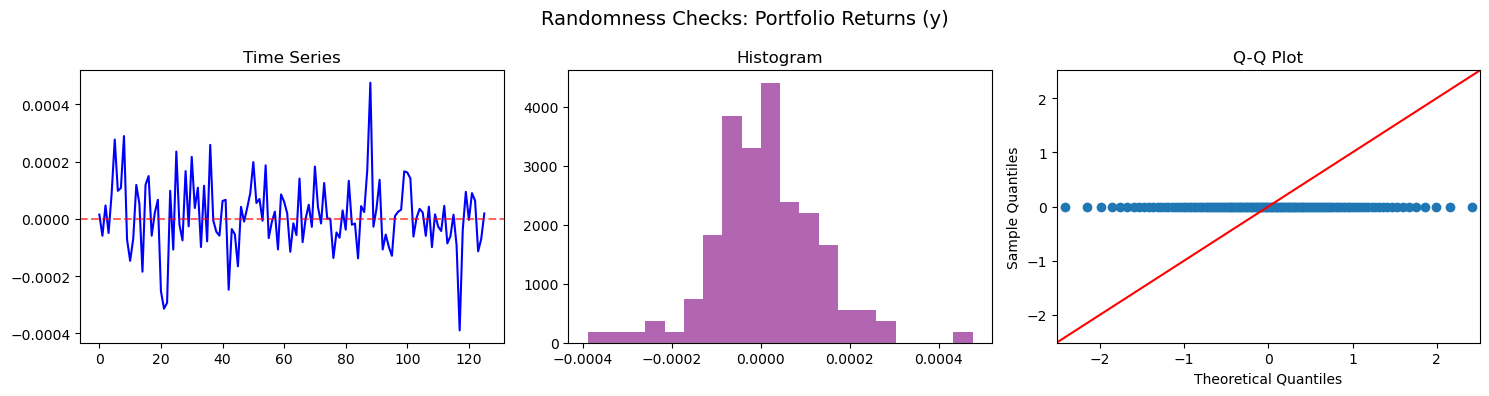


ADF Statistic: -9.7650, p-value: 0.0000

Ljung–Box Test (lag=10):
      lb_stat  lb_pvalue
10  10.334213   0.411677

Runs Test p-value: 0.3711
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     5.808
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           1.90e-06
Time:                        19:17:32   Log-Likelihood:                 1155.2
No. Observations:                 126   AIC:                            -2110.
Df Residuals:                      26   BIC:                            -1827.
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025

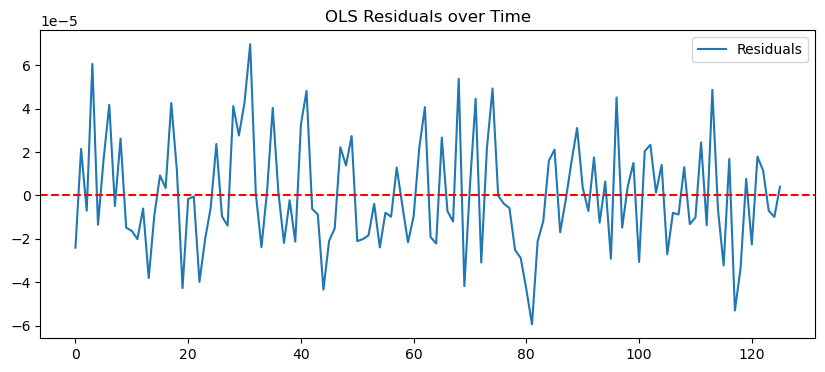

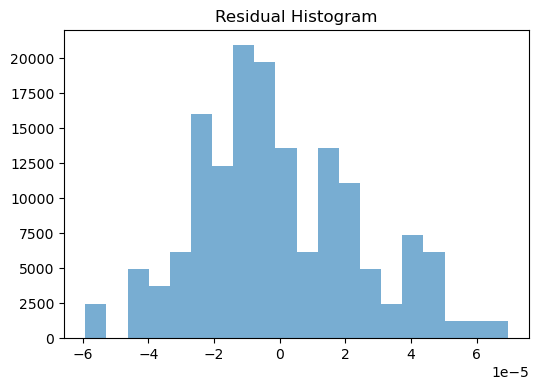

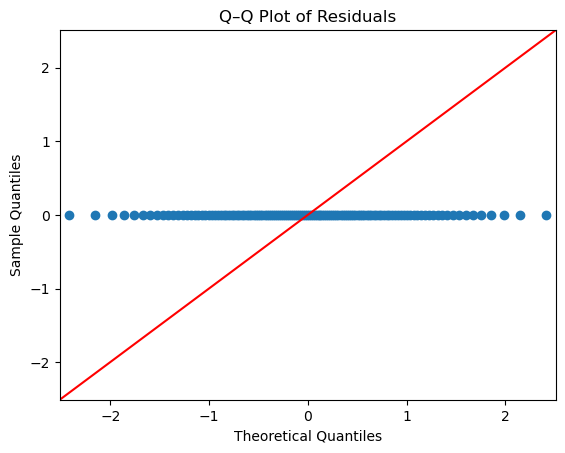


Ljung–Box test (lag=10):
      lb_stat  lb_pvalue
10  13.619132   0.191084

Breusch–Pagan test:
LM stat=98.959, p-value=0.539


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.sandbox.stats.runs import runstest_1samp

# ---- STEP 1: Load dataset ----
# Replace with your actual path
# The dataset should have "Date" column + asset return columns
# Ken French returns are in percentages, so divide by 100
returns = pd.read_csv("/users/utkarshtyagi/documents/vsc/dataset/100_portfolios_me_op_10x10_daily_with_EW.csv", parse_dates=[0], index_col=0) / 100

# ---- STEP 2: Pick a training window ----
TRAIN_WINDOW = 126
returns_train = returns.iloc[:TRAIN_WINDOW]   # first 126 trading days

# ---- STEP 3: Build y and X as in project setup ----
p = returns_train.shape[1]
w_EW = np.ones(p) / p
N = np.vstack([np.eye(p-1), -np.ones((1, p-1))])

R = returns_train.values   # (n, p)
y = R.dot(w_EW)            # (n,)
X = R.dot(N)               # (n, p-1)
def randomness_and_risk_checks(series, label="Series"):
    series = pd.Series(series).dropna()

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Randomness Checks: {label}", fontsize=14)

    # 1. Time series plot
    axes[0].plot(series, color="blue")
    axes[0].axhline(0, color="red", linestyle="--", alpha=0.6)
    axes[0].set_title("Time Series")

    # 2. Histogram
    axes[1].hist(series, bins=20, density=True, alpha=0.6, color="purple")
    axes[1].set_title("Histogram")

    # 3. Q-Q plot (normality check)
    sm.qqplot(series, line="45", ax=axes[2])
    axes[2].set_title("Q-Q Plot")

    plt.tight_layout()
    plt.show()

    # --- Statistical tests ---
    adf_result = adfuller(series)
    print(f"\nADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")

    lb_test = acorr_ljungbox(series, lags=[10], return_df=True)
    print("\nLjung–Box Test (lag=10):")
    print(lb_test)

    runs_pval = runstest_1samp(series)[1]
    print(f"\nRuns Test p-value: {runs_pval:.4f}")

randomness_and_risk_checks(y, label="Portfolio Returns (y)")

# ---- STEP 4: Fit OLS ----
X_const = sm.add_constant(X)   # add intercept
ols_model = sm.OLS(y, X_const).fit()
resid = ols_model.resid

print(ols_model.summary())

# ---- STEP 5: Residual diagnostics ----

# Residual time series
plt.figure(figsize=(10,4))
plt.plot(resid, label="Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.title("OLS Residuals over Time")
plt.legend()
plt.show()

# Histogram + Q-Q plot
plt.figure(figsize=(6,4))
plt.hist(resid, bins=20, density=True, alpha=0.6)
plt.title("Residual Histogram")
plt.show()

sm.qqplot(resid, line="45")
plt.title("Q–Q Plot of Residuals")
plt.show()

# Ljung–Box test (autocorrelation)
lb_test = acorr_ljungbox(resid, lags=[10], return_df=True)
print("\nLjung–Box test (lag=10):")
print(lb_test)

# Breusch–Pagan test (heteroskedasticity)
bp_test = het_breuschpagan(resid, ols_model.model.exog)
print("\nBreusch–Pagan test:")
print(f"LM stat={bp_test[0]:.3f}, p-value={bp_test[1]:.3f}")




In [14]:


TRAIN_WINDOW = 126

def minvar_weights(R):
    """
    Compute minimum variance portfolio weights given training returns R (n x p).
    """
    Sigma = np.cov(R, rowvar=False)  # covariance matrix (p x p)
    ones = np.ones(Sigma.shape[0])
    inv = np.linalg.pinv(Sigma)      # pseudo-inverse for numerical stability
    w = inv.dot(ones) / (ones.dot(inv).dot(ones))
    return w

def rolling_minvar(returns, train_window=TRAIN_WINDOW):
    """
    Rolling-window backtest of MinVar portfolio.
    returns: DataFrame (rows=dates, cols=assets)
    train_window: lookback window size
    """
    results = []
    weights = []
    
    for idx in range(train_window, len(returns)):
        # Training sample
        R_train = returns.iloc[idx-train_window:idx].values  # (n x p)
        # Compute weights
        w = minvar_weights(R_train)
        # Next-day return
        ret_day = returns.iloc[idx].values.dot(w)
        
        results.append((returns.index[idx], ret_day))
        weights.append((returns.index[idx], w))
    
    # Convert to DataFrame
    res_df = pd.DataFrame(results, columns=["Date", "MinVar"]).set_index("Date")
    w_df = pd.DataFrame({d: w for d, w in weights}).T
    w_df.index = res_df.index  # align
    
    return res_df, w_df

# ---- Example usage ----
# returns = pd.read_csv("ff_100portfolios.csv", parse_dates=["Date"], index_col="Date") / 100
# res_minvar, w_minvar = rolling_minvar(returns, TRAIN_WINDOW)

# Merge MinVar returns back into dataset
# returns = returns.join(res_minvar)

# print(returns.head())


In [15]:
def minvar_weights(R):
    """
    Compute minimum variance portfolio weights given training returns R (n x p).
    """
    Sigma = np.cov(R, rowvar=False)  # covariance matrix (p x p)
    ones = np.ones(Sigma.shape[0])
    inv = np.linalg.pinv(Sigma)      # pseudo-inverse for numerical stability
    w = inv.dot(ones) / (ones.dot(inv).dot(ones))
    return w

def ols_weights(R_train, N):
    """
    Compute OLS portfolio weights using y = Xβ + ε structure.
    R_train: training returns matrix (n x p)
    N: number of predictive assets (first N columns are predictors)
    """
    n, p = R_train.shape
    
    if N >= p:
        raise ValueError(f"N ({N}) must be less than total assets ({p})")
    
    # Last asset is the target (y)
    y = R_train[:, -1]  # (n,)
    
    # First N assets are predictors (X)
    X = R_train[:, :N]  # (n, N)
    
    # Add intercept
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    
    # OLS regression
    beta = np.linalg.lstsq(X_with_intercept, y, rcond=None)[0]
    
    # Create portfolio weights: negative betas for predictors, positive for target
    w_ols = np.zeros(p)
    w_ols[:N] = -beta[1:]  # Negative weights for predictors (hedging)
    w_ols[-1] = 1.0        # Positive weight for target asset
    
    # Normalize to sum to 1 (long-short portfolio)
    w_ols = w_ols / np.sum(np.abs(w_ols))
    
    return w_ols

def rolling_minvar_ols(returns, train_window=TRAIN_WINDOW, N=5):
    """
    Rolling-window backtest of both MinVar and OLS portfolios.
    returns: DataFrame (rows=dates, cols=assets)
    train_window: lookback window size
    N: number of predictive assets for OLS (first N columns used as predictors)
    """
    results = []
    weights_minvar = []
    weights_ols = []
    
    for idx in range(train_window, len(returns)):
        # Training sample
        R_train = returns.iloc[idx-train_window:idx].values  # (n x p)
        
        try:
            # Compute MinVar weights
            w_minvar = minvar_weights(R_train)
            
            # Compute OLS weights
            w_ols = ols_weights(R_train, N)
            
            # Next-day returns
            ret_day_minvar = returns.iloc[idx].values.dot(w_minvar)
            ret_day_ols = returns.iloc[idx].values.dot(w_ols)
            
            results.append((returns.index[idx], ret_day_minvar, ret_day_ols))
            weights_minvar.append((returns.index[idx], w_minvar))
            weights_ols.append((returns.index[idx], w_ols))
            
        except (np.linalg.LinAlgError, ValueError) as e:
            # Handle numerical issues or invalid N values
            print(f"Warning: Error at index {idx}, date {returns.index[idx]}: {e}")
            continue

=== Lasso Portfolio Weight Analysis ===
Time periods: 122
Number of assets: 102
Average sparsity (zero weights): 0.00%
Sparsity range: [0.00%, 0.00%]

Weight volatility (std dev across time):
Min: 0.000000
Max: 0.062455
Mean: 0.001849


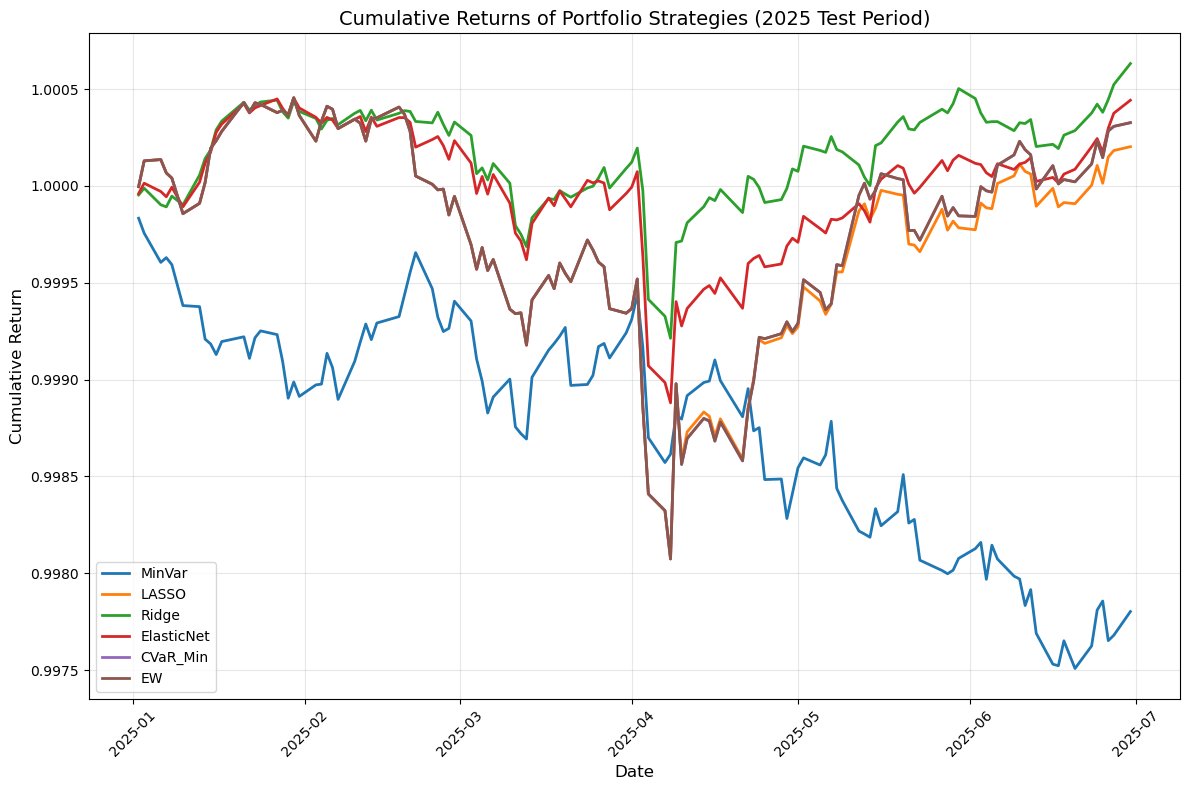

Sharpe Ratios (2025-01-02 to 2025-06-30):
Ridge         0.051497
ElasticNet    0.032470
CVaR_Min      0.016427
EW            0.016427
LASSO         0.010398
MinVar       -0.132148
dtype: float64


In [30]:

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult
from pypfopt import EfficientCVaR

def construct_ew_weights(p):
    """Construct equally weighted portfolio weights."""
    return np.ones(p) / p

def construct_N_matrix(p):
    """
    Construct the N matrix for the linear regression transformation.
    N = [I_{p-1}; -1^T] where I is identity matrix of size (p-1)
    """
    I = np.eye(p-1)
    ones_row = -np.ones((1, p-1))
    N = np.vstack([I, ones_row])
    return N

def portfolio_from_beta(beta, p):
    """
    Convert beta coefficients to portfolio weights using w = w_EW - N * beta
    """
    w_ew = construct_ew_weights(p)
    N = construct_N_matrix(p)
    w = w_ew - N.dot(beta)
    return w

def linear_regression_portfolio(R_train):
    """
    Compute portfolio using the regression framework: y = R * w_EW, X = R * N
    This follows the project's mathematical transformation
    """
    n, p = R_train.shape
    
    # Construct y and X matrices as described in the project
    w_ew = construct_ew_weights(p)
    N = construct_N_matrix(p)
    
    y = R_train.dot(w_ew)  # (n,)
    X = R_train.dot(N)     # (n, p-1)
    
    return y, X, w_ew, N


def lasso_portfolio(R_train, alphas=np.logspace(-8, 8, 21)):
    """
    Compute LASSO-regularized portfolio using cross-validation.
    """
    y, X, w_ew, N = linear_regression_portfolio(R_train)
    
    # LASSO with cross-validation
    lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)
    lasso_cv.fit(X, y)
    
    beta_lasso = lasso_cv.coef_
    w_lasso = portfolio_from_beta(beta_lasso, R_train.shape[1])
    
    return w_lasso, lasso_cv.alpha_

def ridge_portfolio(R_train, alphas=np.logspace(-8, 8, 21)):
    """
    Compute Ridge-regularized portfolio using cross-validation.
    """
    y, X, w_ew, N = linear_regression_portfolio(R_train)
    
    # Ridge with cross-validation
    ridge_cv = RidgeCV(alphas=alphas, cv=5)
    ridge_cv.fit(X, y)
    
    beta_ridge = ridge_cv.coef_
    w_ridge = portfolio_from_beta(beta_ridge, R_train.shape[1])
    
    return w_ridge, ridge_cv.alpha_

def elastic_net_portfolio(R_train, alphas=np.logspace(-8, 8, 21), l1_ratios=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]):
    """
    Compute Elastic Net-regularized portfolio using cross-validation.
    """
    y, X, w_ew, N = linear_regression_portfolio(R_train)
    
    # Elastic Net with cross-validation
    enet_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, random_state=42, max_iter=10000)
    enet_cv.fit(X, y)
    
    beta_enet = enet_cv.coef_
    w_enet = portfolio_from_beta(beta_enet, R_train.shape[1])
    
    return w_enet, enet_cv.alpha_, enet_cv.l1_ratio_

def cvar_pypfopt(R_train, alpha=0.05):
    """CVaR using PyPortfolioOpt (more reliable)"""
    from pypfopt import EfficientCVaR
    
    ef = EfficientCVaR(np.mean(R_train, axis=0), np.cov(R_train.T))
    ef.min_cvar(alpha=alpha)
    weights = ef.clean_weights()
    w_array = np.array([weights[i] for i in range(len(weights))])
    
    port_returns = R_train @ w_array
    var = np.quantile(port_returns, alpha)
    cvar = port_returns[port_returns <= var].mean()
    
    return w_array, cvar
def analyze_lasso_weights(portfolio_weights):
    """Analyze Lasso weight characteristics"""
    lasso_weights = portfolio_weights['LASSO']
    
    print("=== Lasso Portfolio Weight Analysis ===")
    print(f"Time periods: {len(lasso_weights)}")
    print(f"Number of assets: {lasso_weights.shape[1]}")
    
    # Calculate sparsity over time
    sparsity_ratio = []
    for date, weights in lasso_weights.iterrows():
        zero_weights = np.sum(np.abs(weights) < 1e-6)  # Count near-zero weights
        sparsity = zero_weights / len(weights)
        sparsity_ratio.append(sparsity)
    
    print(f"Average sparsity (zero weights): {np.mean(sparsity_ratio):.2%}")
    print(f"Sparsity range: [{np.min(sparsity_ratio):.2%}, {np.max(sparsity_ratio):.2%}]")
    
    # Weight stability
    weight_volatility = lasso_weights.std(axis=0)
    print(f"\nWeight volatility (std dev across time):")
    print(f"Min: {weight_volatility.min():.6f}")
    print(f"Max: {weight_volatility.max():.6f}")
    print(f"Mean: {weight_volatility.mean():.6f}")
    
    return sparsity_ratio

# Run the analysis
sparsity_results = analyze_lasso_weights(portfolio_weights)
    
def rolling_all_strategies(returns, train_window=TRAIN_WINDOW):
    """
    Rolling-window backtest of ALL strategies: MinVar, OLS, LASSO, Ridge, EW
    """
    results = []
    weights_history = {'MinVar': [], 'LASSO': [], 'Ridge': [], 'ElasticNet': [],'CVaR_Min': [],'EW': []}
    
    for idx in range(train_window, len(returns)):
        # Training sample
        R_train = returns.iloc[idx-train_window:idx].values  # (n x p)
        current_date = returns.index[idx]
        
        try:
            day_results = {'Date': current_date}
            day_weights = {'Date': current_date}
            
            # 1. Minimum Variance portfolio (your existing function)
            w_minvar = minvar_weights(R_train)
            day_results['MinVar'] = returns.iloc[idx].values.dot(w_minvar)
            day_weights['MinVar'] = w_minvar
            
            # 3. LASSO portfolio
            w_lasso, alpha_lasso = lasso_portfolio(R_train)
            day_results['LASSO'] = returns.iloc[idx].values.dot(w_lasso)
            day_weights['LASSO'] = w_lasso
            
            # 4. Ridge portfolio
            w_ridge, alpha_ridge = ridge_portfolio(R_train)
            day_results['Ridge'] = returns.iloc[idx].values.dot(w_ridge)
            day_weights['Ridge'] = w_ridge
            
            # 5. Elastic Net portfolio (NEW)
            w_enet, alpha_enet, l1_ratio_enet = elastic_net_portfolio(R_train)
            day_results['ElasticNet'] = returns.iloc[idx].values.dot(w_enet)
            day_weights['ElasticNet'] = w_enet
            
            # 6. CVaR Minimum portfolio (NEW)
            w_cvar, best_cvar = cvar_minimization_weights(R_train)
            day_results['CVaR_Min'] = returns.iloc[idx].values.dot(w_cvar)
            day_weights['CVaR_Min'] = w_cvar

            # 7. Equally Weighted portfolio (benchmark)
            w_ew = construct_ew_weights(R_train.shape[1])
            day_results['EW'] = returns.iloc[idx].values.dot(w_ew)
            day_weights['EW'] = w_ew
            
            results.append(day_results)
            
            # Store weights for each strategy
            for strategy in weights_history.keys():
                weights_history[strategy].append((current_date, day_weights[strategy]))
                
        except Exception as e:
            print(f"Warning: Error at {current_date}: {e}")
            continue
    
    # Convert to DataFrames
    returns_df = pd.DataFrame(results).set_index('Date')
    
    # Create weights DataFrames
    weights_dfs = {}
    for strategy, weight_list in weights_history.items():
        weights_data = [(d, w) for d, w in weight_list]
        weights_df = pd.DataFrame({d: w for d, w in weights_data}).T
        weights_df.columns = [f"{strategy}_Asset_{i}" for i in range(weights_df.shape[1])]
        weights_df.index.name = 'Date'
        weights_dfs[strategy] = weights_df
    
    return returns_df, weights_dfs

    

# ---- Plotting function ----
def plot_cumulative_returns(returns_df, start_date='2025-01-02', end_date='2025-08-30'):
    """
    Plot cumulative returns for all portfolio strategies.
    """
    # Filter for the test period
    test_returns = returns_df.loc[start_date:end_date]
    
    # Calculate cumulative returns
    cumulative_returns = (1 + test_returns).cumprod()
    
    # Plot
    plt.figure(figsize=(12, 8))
    for strategy in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[strategy], 
                label=strategy, linewidth=2)
    
    plt.title('Cumulative Returns of Portfolio Strategies (2025 Test Period)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return cumulative_returns

def calculate_sharpe_ratios(returns_df, start_date='2025-01-02', end_date='2025-06-30'):
    """
    Calculate Sharpe ratios for the validation period.
    """
    validation_returns = returns_df.loc[start_date:end_date]
    
    sharpe_ratios = {}
    for strategy in validation_returns.columns:
        mean_return = validation_returns[strategy].mean()
        std_return = validation_returns[strategy].std()
        sharpe_ratios[strategy] = mean_return / std_return if std_return > 0 else 0
    
    return pd.Series(sharpe_ratios)

# ---- Usage example (add this to your main code) ----
# Run the complete backtest with all strategies
portfolio_returns, portfolio_weights = rolling_all_strategies(returns)

# Plot results
cumulative_returns = plot_cumulative_returns(portfolio_returns)

# Calculate Sharpe ratios
sharpe_ratios = calculate_sharpe_ratios(portfolio_returns)
print("Sharpe Ratios (2025-01-02 to 2025-06-30):")
print(sharpe_ratios.sort_values(ascending=False))

# Save results if needed
portfolio_returns.to_csv('all_portfolio_returns_2025.csv')


Starting comprehensive randomness analysis of both RETURNS and RISK...

ANALYZING RETURN RANDOMNESS

=== RETURN RANDOMNESS ANALYSIS: MinVar ===
Analyzing 122 return observations

MinVar Returns Randomness Results:
  Mean: -0.000018
  Std: 0.000136
  Stationary: True
  Autocorrelation present: False
  Random by runs test: N/A

=== RETURN RANDOMNESS ANALYSIS: OLS ===
Analyzing 122 return observations

OLS Returns Randomness Results:
  Mean: -0.000018
  Std: 0.000136
  Stationary: True
  Autocorrelation present: False
  Random by runs test: N/A

=== RETURN RANDOMNESS ANALYSIS: LASSO ===
Analyzing 122 return observations

LASSO Returns Randomness Results:
  Mean: 0.000002
  Std: 0.000161
  Stationary: True
  Autocorrelation present: False
  Random by runs test: N/A

=== RETURN RANDOMNESS ANALYSIS: Ridge ===
Analyzing 122 return observations

Ridge Returns Randomness Results:
  Mean: 0.000005
  Std: 0.000101
  Stationary: True
  Autocorrelation present: True
  Random by runs test: N/A

=== 

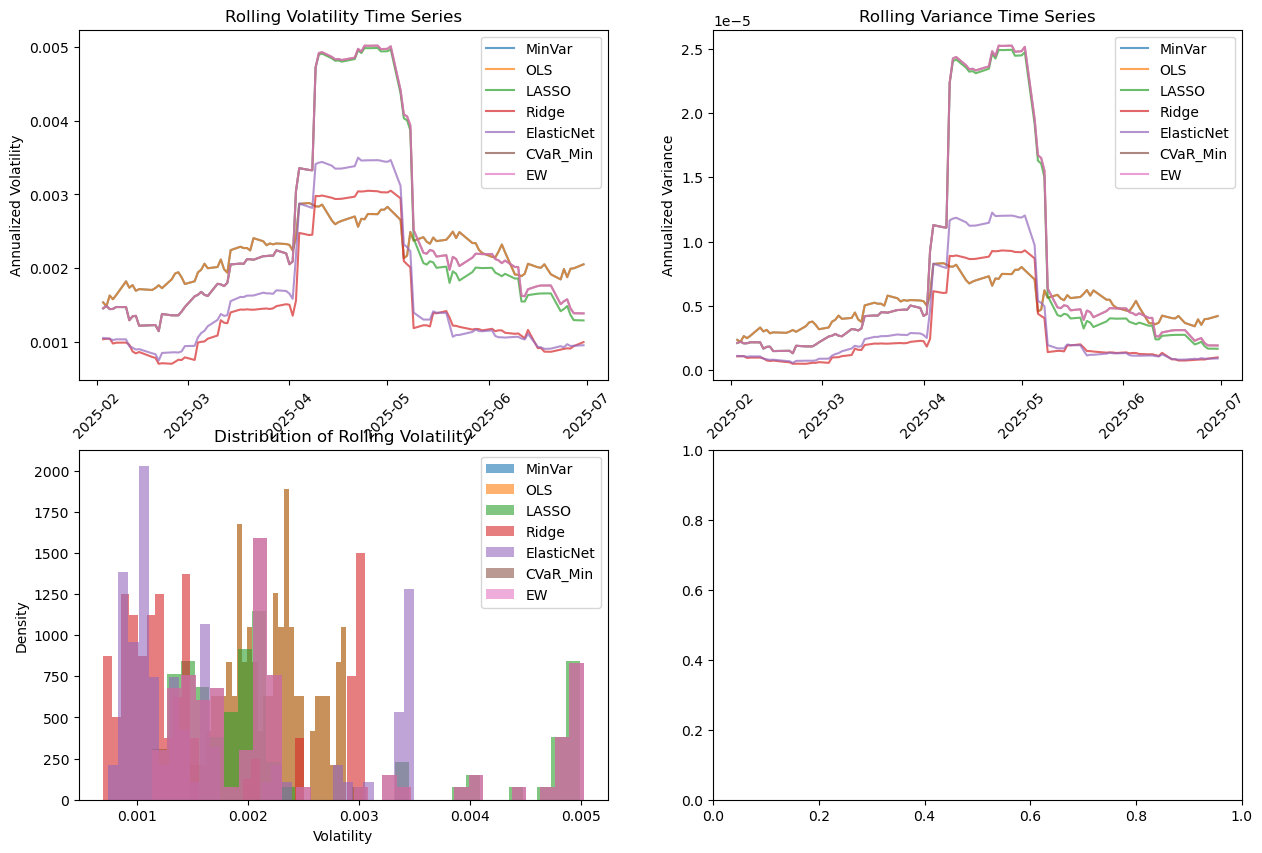

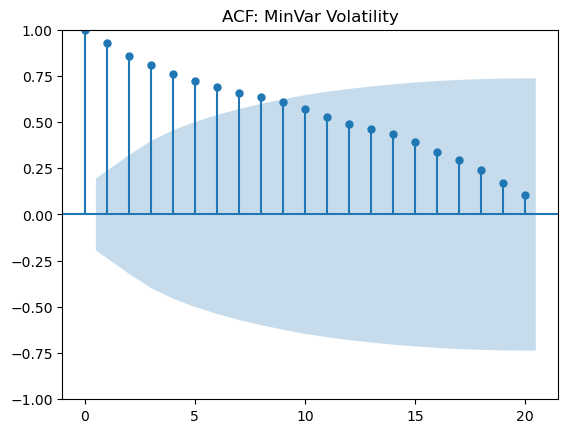

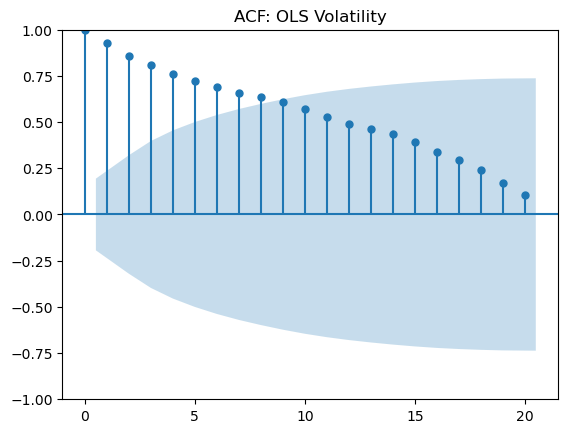

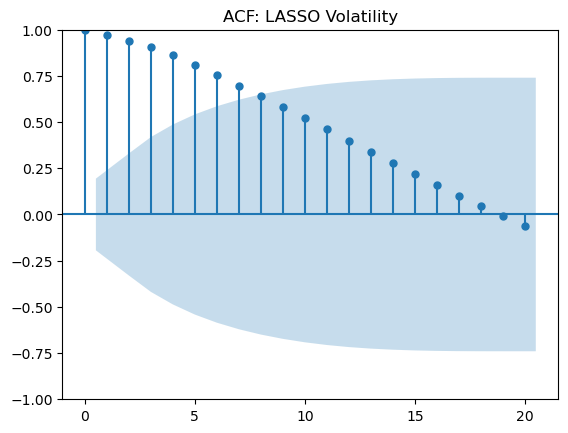

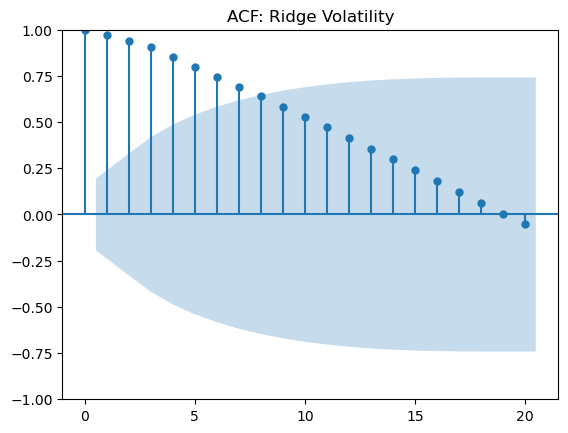

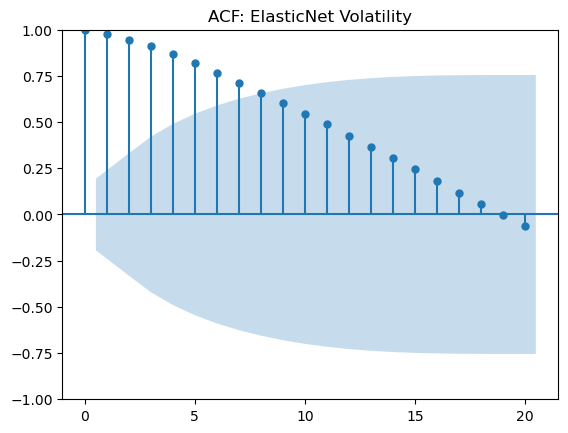

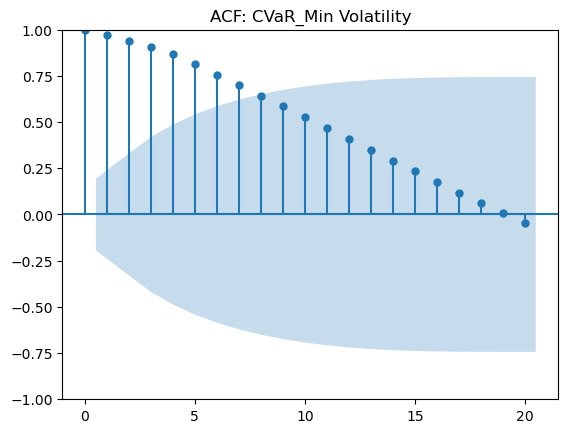

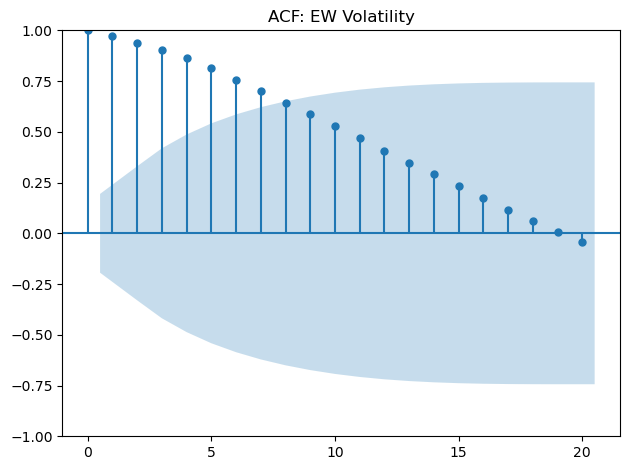


COMPARISON: RETURN vs RISK RANDOMNESS

--- MinVar ---
Returns:
  Stationary: True, Autocorrelation: False
  Mean: -0.000018, Std: 0.000136
Volatility (Risk):
  Stationary: False, Autocorrelation: True
  Mean: 0.002214, Std: 0.000360
  → Risk shows more predictable patterns than returns

--- OLS ---
Returns:
  Stationary: True, Autocorrelation: False
  Mean: -0.000018, Std: 0.000136
Volatility (Risk):
  Stationary: False, Autocorrelation: True
  Mean: 0.002214, Std: 0.000360
  → Risk shows more predictable patterns than returns

--- LASSO ---
Returns:
  Stationary: True, Autocorrelation: False
  Mean: 0.000002, Std: 0.000161
Volatility (Risk):
  Stationary: False, Autocorrelation: True
  Mean: 0.002420, Std: 0.001266
  → Risk shows more predictable patterns than returns

--- Ridge ---
Returns:
  Stationary: True, Autocorrelation: True
  Mean: 0.000005, Std: 0.000101
Volatility (Risk):
  Stationary: False, Autocorrelation: True
  Mean: 0.001511, Std: 0.000773
  → Both returns and risk s

In [25]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

def analyze_risk_series(portfolio_returns, window=21):
    """
    Analyze the time series of RISK measures (volatility) for randomness
    """
    strategies = portfolio_returns.columns
    risk_randomness_results = {}
    
    for strategy in strategies:
        returns = portfolio_returns[strategy].dropna()
        
        # Create rolling risk measures (volatility time series)
        rolling_volatility = returns.rolling(window=window).std() * np.sqrt(252)
        rolling_volatility = rolling_volatility.dropna()
        
        # Create rolling variance time series
        rolling_variance = returns.rolling(window=window).var() * 252
        rolling_variance = rolling_variance.dropna()
        
        print(f"\n=== RISK RANDOMNESS ANALYSIS: {strategy} ===")
        print(f"Analyzing {len(rolling_volatility)} periods of rolling risk measures")
        
        # Test randomness of risk measures
        vol_randomness = test_randomness_series(rolling_volatility, f"{strategy} Volatility")
        var_randomness = test_randomness_series(rolling_variance, f"{strategy} Variance")
        
        risk_randomness_results[strategy] = {
            'volatility_randomness': vol_randomness,
            'variance_randomness': var_randomness,
            'volatility_series': rolling_volatility,
            'variance_series': rolling_variance
        }
    
    return risk_randomness_results

def analyze_return_randomness(portfolio_returns):
    """
    Analyze randomness of RETURN series
    """
    strategies = portfolio_returns.columns
    return_randomness_results = {}
    
    for strategy in strategies:
        returns = portfolio_returns[strategy].dropna()
        
        print(f"\n=== RETURN RANDOMNESS ANALYSIS: {strategy} ===")
        print(f"Analyzing {len(returns)} return observations")
        
        return_randomness = test_randomness_series(returns, f"{strategy} Returns")
        return_randomness_results[strategy] = return_randomness
    
    return return_randomness_results

def test_randomness_series(series, series_name):
    """
    Comprehensive randomness tests for any time series (returns or risk measures)
    """
    series_clean = series.dropna()
    
    if len(series_clean) < 10:
        print(f"Warning: Series {series_name} has too few observations ({len(series_clean)})")
        return {'error': 'Insufficient data'}
    
    randomness_results = {}
    
    # 1. Basic statistics
    randomness_results['basic_stats'] = {
        'mean': series_clean.mean(),
        'std': series_clean.std(),
        'skewness': series_clean.skew(),
        'kurtosis': series_clean.kurtosis()
    }
    
    # 2. Stationarity tests
    try:
        adf_result = adfuller(series_clean)
        randomness_results['stationarity'] = {
            'adf_statistic': adf_result[0],
            'p_value': adf_result[1],
            'is_stationary': adf_result[1] < 0.05
        }
    except Exception as e:
        randomness_results['stationarity'] = {'error': f'ADF test failed: {str(e)}'}
    
    # 3. Autocorrelation tests
    try:
        lb_test = acorr_ljungbox(series_clean, lags=[5, 10, 20], return_df=True)
        randomness_results['autocorrelation'] = {
            'ljung_box_pvalues': lb_test['lb_pvalue'].to_dict(),
            'has_autocorrelation': any(lb_test['lb_pvalue'] < 0.05)
        }
    except Exception as e:
        randomness_results['autocorrelation'] = {'error': f'Ljung-Box test failed: {str(e)}'}
    
    # 4. Runs test for randomness
    try:
        runs_result = stats.runstest_1samp(series_clean, correction=False)
        randomness_results['runs_test'] = {
            'statistic': runs_result[0],
            'p_value': runs_result[1],
            'is_random': runs_result[1] > 0.05
        }
    except Exception as e:
        randomness_results['runs_test'] = {'error': f'Runs test failed: {str(e)}'}
    
    # 5. Variance stability (rolling variance of variance)
    rolling_window = min(50, len(series_clean) // 4)
    if rolling_window > 10:
        try:
            rolling_std = series_clean.rolling(window=rolling_window).std()
            variance_of_variance = rolling_std.var()
            randomness_results['variance_stability'] = {
                'variance_of_volatility': variance_of_variance,
                'is_volatile': variance_of_variance > series_clean.var() * 0.1
            }
        except Exception as e:
            randomness_results['variance_stability'] = {'error': f'Variance stability test failed: {str(e)}'}
    
    # Print results safely
    print(f"\n{series_name} Randomness Results:")
    print(f"  Mean: {randomness_results['basic_stats']['mean']:.6f}")
    print(f"  Std: {randomness_results['basic_stats']['std']:.6f}")
    
    # Safe access to nested dictionaries
    stationarity_info = randomness_results.get('stationarity', {})
    if isinstance(stationarity_info, dict) and 'is_stationary' in stationarity_info:
        print(f"  Stationary: {stationarity_info['is_stationary']}")
    else:
        print(f"  Stationary: N/A")
    
    autocorr_info = randomness_results.get('autocorrelation', {})
    if isinstance(autocorr_info, dict) and 'has_autocorrelation' in autocorr_info:
        print(f"  Autocorrelation present: {autocorr_info['has_autocorrelation']}")
    else:
        print(f"  Autocorrelation present: N/A")
    
    runs_info = randomness_results.get('runs_test', {})
    if isinstance(runs_info, dict) and 'is_random' in runs_info:
        print(f"  Random by runs test: {runs_info['is_random']}")
    else:
        print(f"  Random by runs test: N/A")
    
    return randomness_results

def plot_risk_randomness_comparison(risk_randomness_results):
    """
    Visualize the randomness characteristics of risk measures
    """
    strategies = list(risk_randomness_results.keys())
    
    # 1. Plot volatility time series
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for strategy in strategies:
        vol_series = risk_randomness_results[strategy]['volatility_series']
        plt.plot(vol_series.index, vol_series, label=strategy, alpha=0.7)
    plt.title('Rolling Volatility Time Series')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 2. Plot variance time series
    plt.subplot(2, 2, 2)
    for strategy in strategies:
        var_series = risk_randomness_results[strategy]['variance_series']
        plt.plot(var_series.index, var_series, label=strategy, alpha=0.7)
    plt.title('Rolling Variance Time Series')
    plt.ylabel('Annualized Variance')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 3. Volatility distribution comparison
    plt.subplot(2, 2, 3)
    for strategy in strategies:
        vol_series = risk_randomness_results[strategy]['volatility_series']
        plt.hist(vol_series.dropna(), bins=30, alpha=0.6, label=strategy, density=True)
    plt.title('Distribution of Rolling Volatility')
    plt.xlabel('Volatility')
    plt.ylabel('Density')
    plt.legend()
    
    # 4. ACF of volatility (autocorrelation function)
    from statsmodels.graphics.tsaplots import plot_acf
    plt.subplot(2, 2, 4)
    for strategy in strategies:
        vol_series = risk_randomness_results[strategy]['volatility_series'].dropna()
        if len(vol_series) > 20:
            plot_acf(vol_series, lags=min(20, len(vol_series)-1), alpha=0.05, 
                    title=f'ACF: {strategy} Volatility')
    plt.tight_layout()
    plt.show()

def safe_get(dictionary, key, default=None):
    """Safely get value from dictionary, handling nested errors"""
    if isinstance(dictionary, dict):
        return dictionary.get(key, default)
    return default

def compare_risk_return_randomness(return_randomness, risk_randomness):
    """
    Compare randomness properties between returns and risk measures
    """
    print("\n" + "="*60)
    print("COMPARISON: RETURN vs RISK RANDOMNESS")
    print("="*60)
    
    strategies = return_randomness.keys()
    
    for strategy in strategies:
        print(f"\n--- {strategy} ---")
        
        # Return randomness summary (with safe access)
        ret_stats = safe_get(return_randomness[strategy], 'basic_stats', {})
        ret_stationary = safe_get(safe_get(return_randomness[strategy], 'stationarity', {}), 'is_stationary', 'N/A')
        ret_autocorr = safe_get(safe_get(return_randomness[strategy], 'autocorrelation', {}), 'has_autocorrelation', 'N/A')
        
        # Risk randomness summary (volatility) with safe access
        risk_vol_randomness = safe_get(risk_randomness[strategy], 'volatility_randomness', {})
        risk_stats = safe_get(risk_vol_randomness, 'basic_stats', {})
        risk_stationary = safe_get(safe_get(risk_vol_randomness, 'stationarity', {}), 'is_stationary', 'N/A')
        risk_autocorr = safe_get(safe_get(risk_vol_randomness, 'autocorrelation', {}), 'has_autocorrelation', 'N/A')
        
        print("Returns:")
        print(f"  Stationary: {ret_stationary}, Autocorrelation: {ret_autocorr}")
        if ret_stats:
            print(f"  Mean: {ret_stats.get('mean', 'N/A'):.6f}, Std: {ret_stats.get('std', 'N/A'):.6f}")
        else:
            print("  Mean: N/A, Std: N/A")
        
        print("Volatility (Risk):")
        print(f"  Stationary: {risk_stationary}, Autocorrelation: {risk_autocorr}")
        if risk_stats:
            print(f"  Mean: {risk_stats.get('mean', 'N/A'):.6f}, Std: {risk_stats.get('std', 'N/A'):.6f}")
        else:
            print("  Mean: N/A, Std: N/A")
        
        # Key insight: Which is more predictable? (only if both are boolean)
        if isinstance(ret_autocorr, bool) and isinstance(risk_autocorr, bool):
            if ret_autocorr and not risk_autocorr:
                print("  → Returns show more predictable patterns than risk")
            elif risk_autocorr and not ret_autocorr:
                print("  → Risk shows more predictable patterns than returns")
            elif ret_autocorr and risk_autocorr:
                print("  → Both returns and risk show predictable patterns")
            else:
                print("  → Both returns and risk appear random")
        else:
            print("  → Comparison not available due to test errors")

# ---- RUN THE COMPLETE ANALYSIS ----
print("Starting comprehensive randomness analysis of both RETURNS and RISK...")

# 1. Analyze randomness of RETURNS
print("\n" + "="*60)
print("ANALYZING RETURN RANDOMNESS")
print("="*60)
return_randomness_results = analyze_return_randomness(portfolio_returns)

# 2. Analyze randomness of RISK (volatility/variance)
print("\n" + "="*60)
print("ANALYZING RISK RANDOMNESS")
print("="*60)
risk_randomness_results = analyze_risk_series(portfolio_returns)

# 3. Visualize risk randomness
plot_risk_randomness_comparison(risk_randomness_results)

# 4. Compare returns vs risk randomness
compare_risk_return_randomness(return_randomness_results, risk_randomness_results)

# 5. Key insights for optimization target selection
print("\n" + "="*60)
print("OPTIMIZATION TARGET INSIGHTS")
print("="*60)

for strategy in portfolio_returns.columns:
    ret_autocorr = safe_get(safe_get(return_randomness_results[strategy], 'autocorrelation', {}), 'has_autocorrelation', 'N/A')
    risk_autocorr = safe_get(safe_get(risk_randomness_results[strategy], 'volatility_randomness', {}), 'autocorrelation', {})
    risk_autocorr = safe_get(risk_autocorr, 'has_autocorrelation', 'N/A') if isinstance(risk_autocorr, dict) else 'N/A'
    
    print(f"\n{strategy}:")
    if risk_autocorr is True:
        print("  → Risk measures show predictable patterns (good for optimization)")
    elif risk_autocorr is False:
        print("  → Risk measures appear random (harder to optimize)")
    else:
        print("  → Risk measures: Analysis unavailable")
    
    if ret_autocorr is True:
        print("  → Returns show predictable patterns")
    elif ret_autocorr is False:
        print("  → Returns appear random")
    else:
        print("  → Returns: Analysis unavailable")

print("\nAnalysis complete! Use these insights to decide whether to optimize for risk or returns.")
